In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from __future__ import division

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def getData(files):
    f = open("data/"+str(files), "r")
    f1 = f.readlines()
    del f1[0:4]
    a = np.asarray(f1)
    table = []
    for i in range(0, len(a)):
        b = a[i][0:-1].split('\t')
        c = map(float, b[0:6])
        d = np.asarray(c)
        table.append(d)
    table = np.asarray(table)
    pd.set_option('display.float_format', lambda x: '%.6e' % x)
    df = pd.DataFrame(table, columns=['t1', 'v1', 'w1', 't2', 'v2', 'w2'])
    return df

In [3]:
def getChiSq(y, y_fit, sigma):
    chi_sq = 0
    for i in range(len(y)):
        chi_sq += ( (y[i] - y_fit[i]) / sigma[i] )**2
    return chi_sq

In [4]:
def getRedChi2(y, y_fit, sigma, numPar=2):
    chi_sq = getChiSq(y, y_fit, sigma)
    red_chi_sq = chi_sq / (len(y) - numPar)
    p = chi2.pdf(chi_sq, df=(len(y) - numPar))
    print 'reduced chi-square =', '%.2f'%(red_chi_sq), 'p-value =', '%.2f'%(p)
    return red_chi_sq

In [5]:
def integrate(binwidth, yarray, low, high):
    s = 0
    interval = (int)((high - low)/binwidth)
    for i in range(0, interval):
        s = s + binwidth * yarray[i]
    return s

In [6]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [7]:
df_raw = getData('MUO_long.dat')

In [8]:
df_raw.eval('dt = t2 - t1', inplace=True)
df = applyCut(df_raw, 'v1 > 0.05', 'v1 > 0.05')
df = applyCut(df, 'v2 > 0.05', 'v2 > 0.05')

v1 > 0.05 940307  fraction kept: 98.0
v2 > 0.05 82487  fraction kept: 8.8


In [9]:
def decay(x, tau, a):
    return a * np.exp(- x / tau)

In [70]:
def decay1(x, tau, a, c):
    return a * np.exp(-x / tau) + c

In [158]:
low = 4
high = 6
bins = 10
binWidth = (high - low) / bins

Text(0.5,1,'Signal + background')

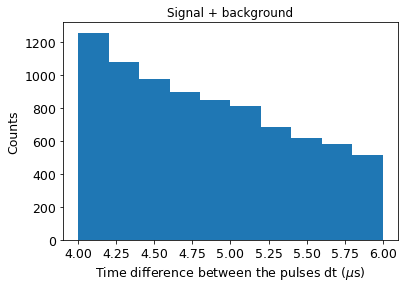

In [159]:
plt.hist(df['dt']*1e6, bins = bins, range=(low, high))
plt.xlabel('Time difference between the pulses dt ($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('Counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Signal + background')

In [160]:
y, binEdges = np.histogram(df['dt']*1e6, bins=bins, range=(low, high))
x = []
for i in range(len(y)):
    x.append((binEdges[i] + binEdges[i+1]) / 2)
x = np.asarray(x)

In [161]:
popt, pcov = curve_fit(decay1, x, y) # pcov is the covariance matrix for the fit parameters

print 'Parameters of binned exponential decay fit y = a * exp( -x / tau):'
print ' tau =','%.3f'%(popt[0]),'micro sec'
print ' a =','%.3f'%(popt[1])
print ' c =','%.3f'%(popt[2])
print ' error on tau =', '%.4f'%(np.sqrt(pcov[0][0])), 'micro sec'
print ' error on a =', '%.4f'%(np.sqrt(pcov[1][1]))

Parameters of binned exponential decay fit y = a * exp( -x / tau):
 tau = 1.870 micro sec
 a = 10082.473
 c = 99.647
 error on tau = 0.6605 micro sec
 error on a = 5720.3830


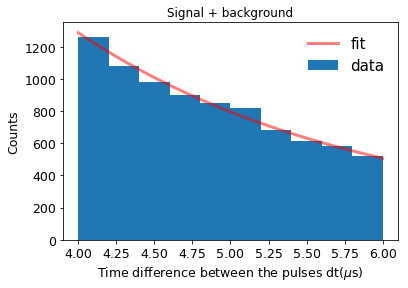

In [164]:
arange = np.arange(low, high+.05, 0.05)
plt.hist(binEdges[:-1], binEdges, weights=y, label='data')
plt.plot(arange, decay1(arange,popt[0],popt[1],popt[2]),label='fit',linewidth=3,alpha=.5,color='r')
plt.xlabel('Time difference between the pulses dt($\mu$s)', fontsize=12.5)
plt.xticks(fontsize=12.5)
plt.ylabel('Counts', fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.title('Signal + background')
plt.legend(prop={'size': 15}, frameon=False, loc='best')

In [163]:
sigma = np.sqrt(y)
getRedChi2(y, decay1(x, popt[0], popt[1], popt[2]), sigma, numPar=3)

reduced chi-square = 1.18 p-value = 0.08


1.1841117306820022